In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Introduction

This project is focused on building a joke recommendation system using collaborative filtering techniques. We have created recommender systems using singular value decomposition (SVD) and k-nearest neighbors (KNN).  The main goal is to provide personalized recommendations to users based on their past joke preferences and ratings.

The dataset used in this project contains information about customer ratings for a 170 jokes. At first data was pre-processed followed by Exploratory Data Analysis (EDA). Then we created a train/test and validation split for each jokes in the dataset. 

For SVD recommender, we used the train set to train a matrix factorization model using singular value decomposition (SVD). We then create a recommender system that is based on joke-similarity to recomended top jokes to user based on their highest rated jokes.

For the KNN recommender, we reduced the dimensionality of the user-joke matrix using SVD. Using this reduced matrix, we create a recommender system that is based on user-similarity (in contrast to joke-similarity), and recommends jokes to users based on the ratings of similar users and their rating history.

Finally, we evaluate the performance of the recommendation system using the test data and calculate the mean square error (MSE) to measure the performance of each model.



## 1.1 Business Question: 
How can we recommend highly relavant jokes to users based on their jokes ratings history?

### 1.1.1 Sub questions:
q1. Based on the highly rated jokes by the user, how can we recommend more relevant jokes to the user?

q2. How can we utilize the preferences and rating history of other users to improve the quality of recommendation to the user?

q3. How can we evaluate the effectiveness of different recommendation models for personalized joke recommendations?

# 2. Data Pre-processing

In [2]:
# Load the CSV files
jester_items = pd.read_csv('data/jester_items.csv')
jester_ratings = pd.read_csv('data/jester_ratings.csv')


We create a new csv which has combined information about all of the users

In [3]:
# Merge the two CSV files based on the common column 'jokeId'
merged_df = pd.merge(jester_items, jester_ratings, on='jokeId')

# Select the desired columns and rename them
merged_df = merged_df[['userId', 'jokeId', 'jokeText', 'rating']]

# Save the merged dataframe to a new CSV file
merged_df.to_csv('merged_jester.csv', index=False)



In [4]:
# Load the merged_jester.csv file into a pandas dataframe
df = pd.read_csv('merged_jester.csv')

In [467]:
# checking the first 5 rows of df
df.head()

,userId,jokeId,jokeText,rating
0,1,5,Q.\tWhat's O. J. Simpson's Internet address? \...,0.219
1,2,5,Q.\tWhat's O. J. Simpson's Internet address? \...,-9.688
2,3,5,Q.\tWhat's O. J. Simpson's Internet address? \...,-9.844
3,4,5,Q.\tWhat's O. J. Simpson's Internet address? \...,-5.812
4,5,5,Q.\tWhat's O. J. Simpson's Internet address? \...,6.906


In [468]:
# checking the number of rows and column of df
df.shape

(1761439, 4)

In [471]:
# checking the total number of users and jokes and the rating range.
num_users = df['userId'].nunique()
print("Total number of users:", num_users)
num_jokes = df['jokeId'].nunique()
print("Total number of jokes:", num_jokes)
df['rating'].min(), df['rating'].max()

Total number of users: 59132
Total number of jokes: 140


(-10.0, 10.0)

Since there are 59132 numbers of users. To minimize the size of the dataset we sample 15% of the users with highest count of ratings.

In [33]:
# Calculate the mean rating for each user
user_count_ratings = df.groupby('userId')['rating'].count().reset_index()

# Sort the users by their mean rating in descending order
user_count_ratings = user_count_ratings.sort_values(by='rating', ascending=False)

# Select the top 15% of users based on their mean rating
n_top_users = int(len(user_count_ratings) * 0.15)
top_users = user_count_ratings.head(n_top_users)['userId'].values

# Sample a fixed percentage of ratings for each selected user
sampled_df = pd.DataFrame()
for user in top_users:
    user_ratings = df[df['userId'] == user]
    sampled_ratings = user_ratings.sample(frac=0.1, random_state=42)
    sampled_df = pd.concat([sampled_df, sampled_ratings])

# Save the sampled DataFrame to a new CSV file
sampled_df.to_csv('sampled_jester.csv', index=False)


In [9]:
sample_df  = pd.read_csv('sampled_jester.csv')

In [10]:
sample_df.shape

(33020, 4)

In [472]:
# checking the total number of users
num_users = sample_df['userId'].nunique()
print("Total number of users:", num_users)

Total number of users: 7527


Here we have reduced the total number of users to 7527 in the sample_df dataset.

# 3. EDA

Exploratory Data Analysis (EDA) is done on data to get an understanding of the data and to identify patterns, relationships, and anomalies in the data. In the context of a this project, EDA helps to identify any data quality issues and the suitability of the data for the intended analysis.

In [473]:
sample_df.head()

,userId,jokeId,jokeText,rating,joke_length,average_rating
0,11433,8,Q. Did you hear about the dyslexic devil worsh...,10.0,84,5.069075
1,51145,87,"A man, recently completing a routine physical ...",10.0,418,6.807288
2,51145,53,One Sunday morning William burst into the livi...,10.0,1217,7.095451
3,51145,29,An old Scotsmen is sitting with a younger Scot...,10.0,741,7.015639
4,51145,89,A radio conversation of a US naval \nship with...,10.0,795,7.347781


In [474]:
#checking null value
null_percentage = sample_df.isna().mean() * 100 #checking the pergentage of null value
print(null_percentage)

userId            0.0
jokeId            0.0
jokeText          0.0
rating            0.0
joke_length       0.0
average_rating    0.0
dtype: float64


In [475]:
sample_df.describe()

,userId,jokeId,rating,joke_length,average_rating
count,33020.000000,33020.000000,33020.000000,33020.00000,33020.000000
mean,33725.484161,73.401211,5.686971,419.46805,5.686971
std,18975.264288,43.764937,4.580714,343.09749,2.011767
min,9.000000,5.000000,-10.000000,52.00000,-9.906000
25%,16150.250000,35.000000,4.219000,124.00000,5.346871
50%,36368.000000,75.000000,7.219000,328.00000,6.485364
75%,50080.750000,114.000000,8.969000,592.00000,7.015639
max,63978.000000,150.000000,10.000000,1326.00000,8.718500


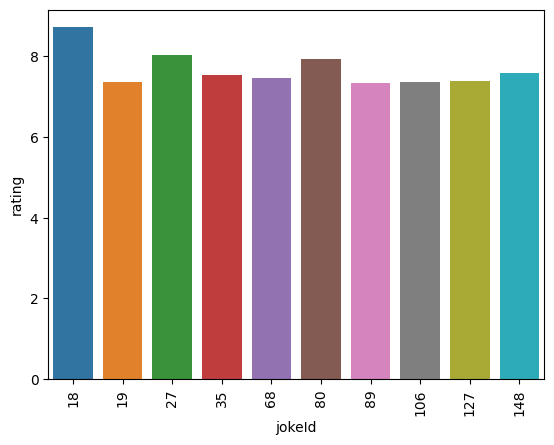

In [476]:
#plotting highly rated top 10 Jokes among the users based on their mean rating
top_jokes = sample_df.groupby('jokeId')['rating'].mean().sort_values(ascending=False)[:10]
top_jokes = sample_df.loc[sample_df['jokeId'].isin(top_jokes.index)]

sns.barplot(x='jokeId', y='rating', data=top_jokes, errorbar=None)
plt.xticks(rotation=90)
plt.show()

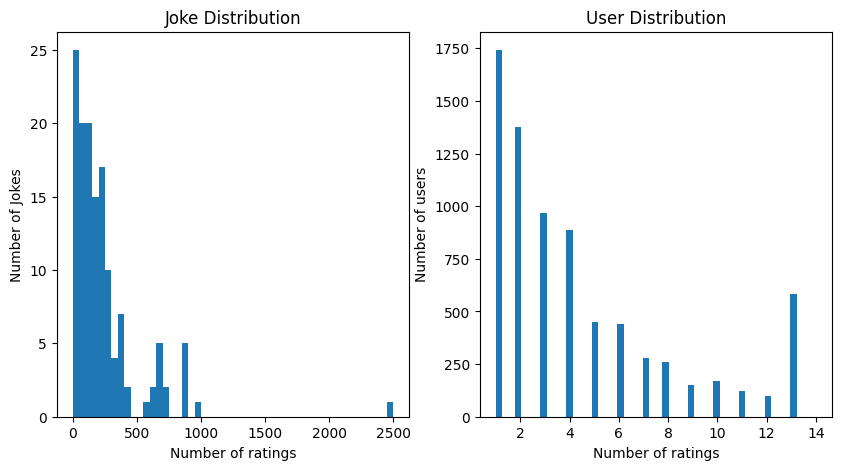

In [477]:
# Count the occurrences of each joke ID and user ID
joke_counts = sample_df['jokeId'].value_counts()
user_counts = sample_df['userId'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the joke distribution on the first subplot
axs[0].hist(joke_counts, bins=50)
axs[0].set_title('Joke Distribution')
axs[0].set_xlabel('Number of ratings')
axs[0].set_ylabel('Number of Jokes')

# Plot the user distribution on the second subplot
axs[1].hist(user_counts, bins=50)
axs[1].set_title('User Distribution')
axs[1].set_xlabel('Number of ratings')
axs[1].set_ylabel('Number of users')

# Show the plot
plt.show()

Here we can see majority of jokes are rated less then 100 times. Similarly, users tend to rate only a few jokes.

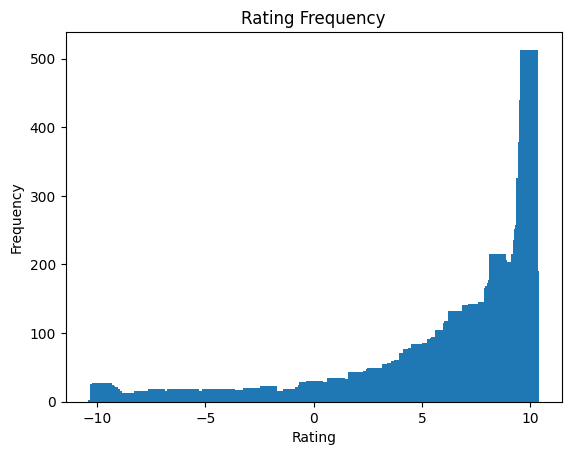

In [17]:
# Checking the distribution of ratings in the dataset.

rating_counts = sample_df['rating'].value_counts()

# Sort the counts by rating value
rating_counts = rating_counts.sort_index()

# Plot the frequency of each rating
plt.bar(rating_counts.index, rating_counts.values)
plt.title('Rating Frequency')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

Here we can see the rating frequency increases towards the highest rating.

Now we check the length of each joke and add joke_length to the df.

In [18]:
# Add a new column to the DataFrame that contains the length of the joke text
sample_df['joke_length'] = sample_df['jokeText'].apply(len)

# Now the "jokes" DataFrame will have a new column called "joke_length" that contains the length of each joke text
print(sample_df.head())

   userId  jokeId                                           jokeText  rating  \
0   11433       8  Q. Did you hear about the dyslexic devil worsh...    10.0   
1   51145      87  A man, recently completing a routine physical ...    10.0   
2   51145      53  One Sunday morning William burst into the livi...    10.0   
3   51145      29  An old Scotsmen is sitting with a younger Scot...    10.0   
4   51145      89  A radio conversation of a US naval \nship with...    10.0   

   joke_length  
0           84  
1          418  
2         1217  
3          741  
4          795  


We also check the average ratings for each joke.

In [19]:
# Group the DataFrame by "jokeId" and compute the mean of the "rating" column for each group
average_ratings = sample_df.groupby('jokeId')['rating'].mean()

# Now you have a Series called "average_ratings" that contains the average rating for each joke ID
print(average_ratings.head())

# Add a new column to the "sample_df" DataFrame that contains the average rating for each joke ID
sample_df['average_rating'] = sample_df['jokeId'].map(average_ratings)

# Now the "sample_df" DataFrame will have a new column called "average_rating" that contains the average rating for each joke ID
print(sample_df.head())


jokeId
5     0.142000
7     0.738944
8     5.069075
15    1.627100
16    0.143194
Name: rating, dtype: float64
   userId  jokeId                                           jokeText  rating  \
0   11433       8  Q. Did you hear about the dyslexic devil worsh...    10.0   
1   51145      87  A man, recently completing a routine physical ...    10.0   
2   51145      53  One Sunday morning William burst into the livi...    10.0   
3   51145      29  An old Scotsmen is sitting with a younger Scot...    10.0   
4   51145      89  A radio conversation of a US naval \nship with...    10.0   

   joke_length  average_rating  
0           84        5.069075  
1          418        6.807288  
2         1217        7.095451  
3          741        7.015639  
4          795        7.347781  


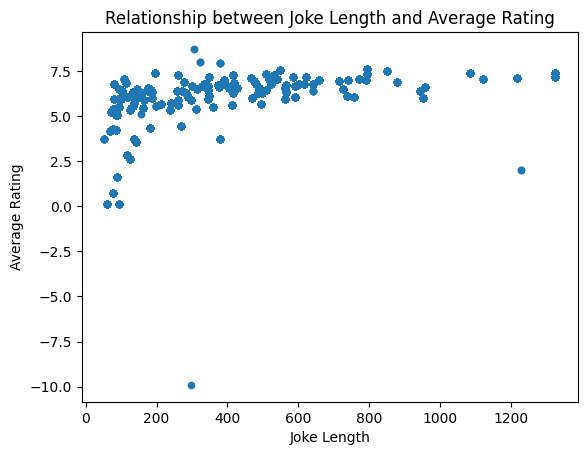

In [20]:
sample_df.plot(kind='scatter', x='joke_length', y='average_rating')

# Set the axis labels and title for the plot
plt.xlabel('Joke Length')
plt.ylabel('Average Rating')
plt.title('Relationship between Joke Length and Average Rating')

# Show the plot
plt.show()


We can see that shorter jokes gets rated more frequently compared to longer jokes.

We check what type of jokes gets more ratings based on the length

In [21]:
# Sort the jokes based on the average rating
jokes_ranked = sample_df.sort_values('average_rating', ascending=False)

# Print the top 5 most popular jokes
print('Top 5 most popular jokes:')
print(jokes_ranked.head(5))

# Print the top 5 least popular jokes
print('Top 5 least popular jokes:')
print(jokes_ranked.tail(5))


Top 5 most popular jokes:
       userId  jokeId                                           jokeText  \
1595      447      18  A dog walks into Western Union and asks the cl...   
16254     240      18  A dog walks into Western Union and asks the cl...   
24737     192      27  Clinton returns from a vacation in Arkansas an...   
18275     652      27  Clinton returns from a vacation in Arkansas an...   
32535     565      27  Clinton returns from a vacation in Arkansas an...   

       rating  joke_length  average_rating  
1595    8.781          306        8.718500  
16254   8.656          306        8.718500  
24737   7.531          324        8.020667  
18275   8.781          324        8.020667  
32535   7.750          324        8.020667  
Top 5 least popular jokes:
       userId  jokeId                                           jokeText  \
13459     148       5  Q.\tWhat's O. J. Simpson's Internet address? \...   
9846      267       5  Q.\tWhat's O. J. Simpson's Internet address? 

Here we can say that longer jokes get rated highly compared to shorter jokes.

# 4.Train/ Test and validation split

We group the data by joke id, and for each joke id we sample data to create train, test and validation set so that all the jokes are included in all three splits.

In [478]:
train_data, test_data, val_data = [], [], []

# Group the dataframe by joke ID and iterate over each group
for jokeId, joke_df in sample_df.groupby('jokeId'):

    # Split the filtered dataframe into train, test, and validation sets
    train = joke_df .sample(frac=0.8, random_state=200)
    temp = joke_df.drop(train. index)
    test = temp.sample(frac=0.5, random_state=200)
    val = temp.drop(test.index)
    
    # Check that each set has at least one entry and append them to their respective lists
    if len(train) < 1 or len(test) < 1 or len(val) < 1:
        continue
    train_data.append (train)
    test_data.append(test)
    val_data.append(val)

In [479]:
# combining these smaller DataFrames into larger ones that contain all the training and testing data, respectively
train_df = pd.concat (train_data)
test_df = pd. concat (test_data)
val_df = pd.concat(val_data)

In [480]:
# checking the length of column in test and train dataframe
len(train_df['jokeId'].unique()), len(test_df['jokeId'].unique()), len(val_df['jokeId'].unique())

(130, 130, 130)

Here we can see that train_df, test_df and val_df has equal number of jokes i.e. 130 jokes.

In [482]:
train_df.shape, test_df.shape, val_df.shape

((26399, 6), (3299, 6), (3299, 6))

# 5. Recommender system using SVD 

We have created a joke based SVD Reccomender system. We choose the users most highest rated joke and recommend top jokes based on that to that user.

To build a recommendation system, we need to transform this tabular data into a matrix where each row represents a user, each column represents a joke, and each entry in the matrix represents the rating given by the user to the joke. This matrix is called a user-item-rating matrix for 'train_df'.All users will not have rated every joke in the dataset, so there will be missing values in the matrix which is replaced by 0.


In [483]:
# transforming 'train_df' into a user-joke matrix
train_matrix = train_df.pivot(index="userId", columns="jokeId", values="rating").fillna(0)

In [484]:
train_matrix

jokeId,5,7,8,15,16,17,19,20,21,22,...,141,142,143,144,145,146,147,148,149,150
userId,,,,,,,,,,,,,,,,,,,,,
9,0.000,0.000,0.0,0.0,0.0,0.000,0.000,-5.938,0.000,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.000,0.000,0.0,0.0,0.0,0.000,6.719,0.000,0.000,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,8.594,0.000,0.0,0.0,0.0,0.000,0.000,0.000,9.969,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,-6.562,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,...,0.0,0.0,9.156,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63951,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63957,0.000,9.844,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63958,0.000,0.000,9.5,0.0,0.0,0.000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We also convert test_df and val_df into user-joke matrixes.

In [489]:
# transforming 'train_df' into a user-joke matrix
test_matrix = test_df.pivot(index="userId", columns="jokeId", values="rating").fillna(0)

In [490]:
# transforming 'val_df' into a user-joke matrix
val_matrix = val_df.pivot(index="userId", columns="jokeId", values="rating").fillna(0)

In [491]:
val_matrix.shape

(2436, 130)

In [492]:
# creating two dictionaries 'joke_id2idx' and 'idx2joke_id' which are used to map joke IDs to and from their corresponding indices in the 'train_matrix'
joke_id2idx = {k: v for v, k in enumerate(train_matrix.columns)}
idx2joke_id = {v: k for v, k in enumerate(train_matrix.columns)}

## 5.1 SVD 

Here we define the functions to perform SVD decomposition of data, transform the data with SVD and reconstruct transformed data for evaluation. We also define a function to get the explained variance ratio of the SVD decomposition to pick the correct hyperparameters.

In [493]:
from scipy.linalg import svd

# Define a function to perform SVD decomposition on a given matrix X
def svd_decomposition(X, n_elements):
    # Perform SVD decomposition on matrix X
    U, s, VT = svd(X, full_matrices=False) 
    # Select only the first n_elements singular values and their corresponding rows in VT
    s = s[:n_elements]  
    VT = VT[:n_elements, :]
    # Return the left singular vectors (U), singular values (s), and right singular vectors (VT) for the given X matrix
    return U, s, VT 

# Define a function to reconstruct a matrix X given its right singular vectors VT
def svd_reconstruct(X, VT):
    return np.dot(X, VT) # Compute the dot product of X and VT to obtain the reconstructed matrix

# Define a function to transform a matrix X using its right singular vectors VT
def svd_transform(X, VT):
    return np.dot(X, VT.T) # Compute the dot product of X and the transpose of VT to obtain the transformed matrix

# Define a function to compute the explained variance ratio for a  matrix X given the right singular vectors VT
def svd_explained_var_ratio(X, VT):  
    X_transformed = np.dot(X, VT.T) # Transform X using VT to obtain the transformed matrix X_transformed
    exp_var = np.var(X_transformed, axis=0)  # Compute the variance of each column in X_transformed
    full_var = np.var(X, axis=0).sum() # Compute the total variance of X by summing the variances of each column
    return (exp_var / full_var).sum() # Compute the ratio of explained variance to total variance and return the sum of these ratios across all columns in X_transformed

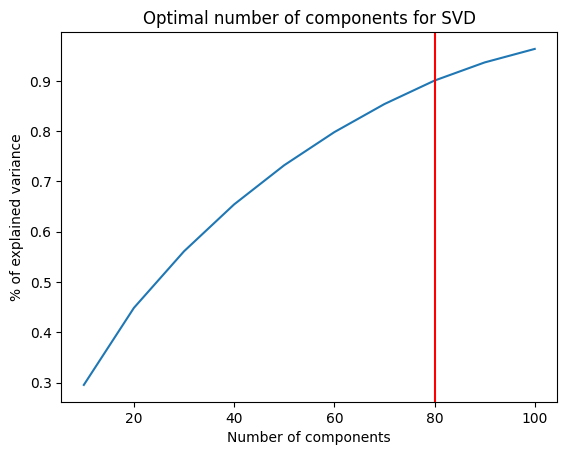

In [494]:
# picking the number of components that explains 90% of variance in the data
import matplotlib.pylab as plt

x, y = [], []

# calculate the explained variance ratio
for i in range(10, 110, 10):
    U, Sigma, VT = svd_decomposition(val_matrix.values.T, n_elements=i)
    var_explained = svd_explained_var_ratio(val_matrix.values.T, VT)
    y.append(var_explained)
    x.append(i)

#plot
plt.plot(x, y)
plt.axvline(x=80, color='r')
plt.title('Optimal number of components for SVD')
plt.xlabel('Number of components')
plt.ylabel("% of explained variance")
plt.show()

After analyzing the plot of the percentage of explained variance against the number of components, we can say that selecting 80 components can provide an explanation for 90% of the variance in the data. Hence, we select 80 as the optimal number of components.

We then performed SVD decomposition on the train_matrix using the svd_decomposition function we defined earlier then, transform the train matrix using the VT matrix obtained from SVD decomposition to obtain the reduced SVD matrix.

In [498]:
# Perform SVD decomposition on the transpose of the train matrix using 147 components
U, Sigma, VT = svd_decomposition(train_matrix.values.T, n_elements=80)

# Transform the train matrix using the VT matrix obtained from SVD decomposition to obtain the reduced SVD matrix
train_svd_matrix = svd_transform(train_matrix.values.T, VT)
train_svd_matrix.shape

(130, 80)

## 5.2 SVD Recommender system

A function svd_recommend is defined that takes in a user ID and recommends n jokes to that customer based on the similarity of the jokes to the ones the customer has already rated, using the cosine similarity measure.

The function selects the joke with the highest rating. Then, cosine similarity between the selected joke and all other jokes is calulated followed by identification of top 5 jokes.

In [499]:
def svd_recommend(userId, train_svd, n=5):
    # defining a function to check similarity between two joke vectors
    def cosine_similarity(v,u):
        return (v @ u)/ (np.linalg.norm(v) * np.linalg.norm(u))

    history = sample_df.query(f"userId == {userId}")
    # Check if user history exists
    if(len(history) == 0):
        print('User history not found')
    else:
        print(history[['jokeText', 'rating']]) 
    max_rating = history['rating'].max() # Find the maximum rating given by the user in their history
    latest = history[history['rating'] == max_rating].iloc[0]
    idx = joke_id2idx[latest['jokeId']]  # Map the joke id to its index and store the result in 'idx' variable

    # Create a list to store similarity scores between the searched joke and all other jokes in the train set
    scores = []
    for i in range(train_svd.shape[0]):
         # get similarity score between searched joke and joke i
        if idx == i: continue
        # get similarity score between searched joke and other jokes
        score = cosine_similarity(train_svd[idx], train_svd[i])
        scores.append(score)


    # Convert scores to a numpy array
    scores = np.array(scores)

    # Sort the scores in descending order and get the indices of the top n jokes
    topn = (-scores).argsort()[:n]
    # Print the joke text of the recommended jokes
    print(topn)
    print('---------------------------------------------------')
    print('Recommended Joke based on the users higest rating:')
    print('---------------------------------------------------')
    for i, idx in enumerate(topn):
        a = idx2joke_id[idx]
        print(idx, df[df['jokeId']==a].iloc[0]['jokeText'])



In [500]:
svd_recommend(46, train_svd_matrix)

                                                jokeText  rating
13842  A neutron walks into a bar and orders a drink....   7.281
13843  Why are there so many Jones's in the phone boo...   8.031
13844  On the first day of college, the Dean addresse...   5.812
13845  The Pope dies and, naturally, goes to heaven. ...   9.938
13846  A preist, a 12-year-old kid, and the smartest ...   9.156
13847  Q: Do you know the difference between an intel...   2.312
13848  Q: What is the Australian word for a boomerang...   9.906
13849  Two atoms are walking down the street when one...   5.844
13850  Q: What's the difference between a Lawyer and ...   6.719
13851  If pro- is the opposite of con- then congress ...   4.156
13852  A man and Cindy Crawford get stranded on a des...   8.531
13853  An engineer, a physicist and a mathematician a...   7.312
13854  A Jewish young man was seeing a psychiatrist f...   1.656
13855  The graduate with a Science degree asks, "Why ...   8.531
[ 60 101 128  23  41]
---

## 5.3 Performance evaluation of SVD

To evaluate the performance of the SVD based recommender, we transform the test dataset to dimensionality reduced SVD matrix. Then, we transform the SVD matrix back to original form which represents our predictions. To compute evaluation metric, we use MSE between original matrix and prediction matrix.

In [502]:
# Perform SVD decomposition on the test matrix and transform it
U, Sigma, VT_test = svd_decomposition(test_matrix.values.T, n_elements=80)
test_svd_matrix = svd_transform(test_matrix.values.T, VT_test)

# Calculate mean squared error between the original test matrix and the reconstructed matrix using the SVD
mse = np.mean((test_matrix.T.values - svd_reconstruct(test_svd_matrix, VT_test))**2)
mse

0.05563385488919959

# 6. Recommendation system using KNN


We now create a user-similarity based KNN Reccomender system. Initially, we do dimentinality reduction of user_joke_matrix using SVD. Then we create a cosine similarity matrix between all users represented in the SVD martix. Then to get the nearest neighbors for a particular user, we compute the similarity score between the user and all the other users in the SVD matrix. Then to recommend jokes to the user, we select jokes that were rated highly (>5) by the neighbors.

In [213]:
# Creating a sparse matrix
user_joke_matrix = train_df.pivot(index="userId", columns="jokeId", values="rating").fillna(0)
user_joke_matrix

jokeId,5,7,8,15,16,17,19,20,21,22,...,141,142,143,144,145,146,147,148,149,150
userId,,,,,,,,,,,,,,,,,,,,,
9,0.000,0.000,0.0,0.0,0.0,0.000,0.000,-5.938,0.000,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.000,0.000,0.0,0.0,0.0,0.000,6.719,0.000,0.000,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,8.594,0.000,0.0,0.0,0.0,0.000,0.000,0.000,9.969,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,-6.562,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,...,0.0,0.0,9.156,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63951,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63957,0.000,9.844,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63958,0.000,0.000,9.5,0.0,0.0,0.000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6.1 SVD

In [414]:
# Performing SVD on the user-joke matrix
U, s, VT = svd_decomposition(user_joke_matrix.values, n_elements=80)
user_joke_matrix_svd = svd_transform(user_joke_matrix.values, VT)
user_joke_matrix_svd.shape


(7105, 80)

## 6.2 KNN

In [415]:
from sklearn.metrics.pairwise import cosine_similarity

# compute pairwise similarity matrix of all the users in the user_joke_matrix_svd.
similarities = cosine_similarity(user_joke_matrix_svd)

# put the similarity scores in a dataframe.
cosine_similarity_df = pd.DataFrame(similarities, index = user_joke_matrix.index, columns = user_joke_matrix.index)
cosine_similarity_df

userId,9,17,41,42,46,49,51,54,64,65,...,63926,63927,63938,63944,63947,63951,63957,63958,63966,63978
userId,,,,,,,,,,,,,,,,,,,,,
9,1.000000,-0.003568,-0.007351,-0.011476,0.023290,-0.016165,-0.002272,-0.013460,-0.005680,-0.000605,...,0.000077,0.008439,0.000031,0.003467,-0.010267,0.001827,-0.000371,0.000031,0.000583,-0.000359
17,-0.003568,1.000000,0.006813,0.001372,-0.010234,0.013930,0.000612,0.009306,-0.003523,0.113631,...,0.000976,-0.011237,-0.000047,0.008430,-0.005506,-0.000866,0.000535,-0.000047,0.000628,0.000428
41,-0.007351,0.006813,1.000000,-0.002984,0.232338,-0.004885,-0.005484,0.407210,0.341282,0.456376,...,0.000758,0.002785,-0.000144,-0.009981,-0.000487,-0.008931,0.001644,-0.000144,-0.001098,-0.145417
42,-0.011476,0.001372,-0.002984,1.000000,-0.010059,0.006006,0.018506,-0.024432,-0.017106,-0.015240,...,-0.000973,0.030142,0.000290,0.011980,0.466712,-0.001071,-0.003327,0.000290,0.002979,0.001402
46,0.023290,-0.010234,0.232338,-0.010059,1.000000,-0.004566,-0.004753,-0.100321,0.216364,0.059116,...,0.001644,-0.026777,-0.000154,0.268660,0.016007,0.000453,0.001850,-0.000154,-0.000166,0.040277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63951,0.001827,-0.000866,-0.008931,-0.001071,0.000453,-0.000711,0.005706,-0.004087,0.189564,0.009040,...,0.000278,0.004669,-0.000026,0.283282,0.002494,1.000000,0.000302,-0.000026,-0.000013,0.167743
63957,-0.000371,0.000535,0.001644,-0.003327,0.001850,0.000353,0.000837,-0.002642,-0.000181,0.002784,...,0.714459,0.000894,0.000053,-0.090636,0.000322,0.000302,1.000000,0.000053,-0.325114,0.000095
63958,0.000031,-0.000047,-0.000144,0.000290,-0.000154,-0.000032,-0.000075,0.000228,0.000014,-0.000242,...,0.000041,-0.000079,1.000000,-0.000051,-0.000032,-0.000026,0.000053,1.000000,-0.000014,-0.000008


To evaluate the performance of this model we generate prediction ratings for each users based on their nearest neighbours. Then we compute MSE score to get evaluation metrix.

In [509]:
def knn_evaluate(df, n):
     # create user_joke matrix from the dataframe.
    user_joke_matrix = df.pivot(index="userId", columns="jokeId", values="rating").fillna(0)
    # keep track of index in the matrix to cusotmer id using a dict.
    idx2user_id = {v: k for v, k in enumerate(user_joke_matrix.index)}
    # do SVD decomposition on user_joke matrix.
    U, Sigma, VT_test = svd_decomposition(user_joke_matrix.values, n_elements=80)
    # get transformed matrix from the SVD.
    user_joke_matrix_svd = svd_transform(user_joke_matrix.values, VT_test)

    pred_matrix = []
    # now iterate over all the users in the user_joke_matrix to create predictions.
    for i, r in user_joke_matrix.iterrows():
        ratings = r.values
        # indexes of jokes rated by this user.
        rated_idxs = np.where(ratings != 0)[0]
        # get vector of this using SVD.
        ratings_svd = svd_transform(ratings.reshape((1, -1)), VT_test)
        
         # compute similarity score of this user against all the users.
        user_similarity = np.dot(ratings_svd, user_joke_matrix_svd.T).flatten()

         # get the n users with largest similarity.
        neighbors = (-user_similarity).argsort()[:n]
        # get customer ids from the indices of the neighbor.
        user_idxs = [idx2user_id[n] for n in neighbors]
        # get all the ratings for each neighbors.
        neighbor_ratings = user_joke_matrix.loc[user_idxs].values[:,rated_idxs]
        predicted_ratings = []
        # iterate over each jokes (columns)
        for col_idx in range(neighbor_ratings.shape[1]):
            non_zero_indices = np.nonzero(neighbor_ratings[:, col_idx])[0]
            if len(non_zero_indices) == 0:
                predicted_ratings.append(0)
            else:
                 # predicted rating is the mean of rating for this joke by all the neighbors.
                pred = np.mean(neighbor_ratings[:, col_idx][non_zero_indices])
                predicted_ratings.append(pred)
        pred_ratings = np.zeros(VT_test.shape[1])
        # put the predicted ratings in appropriates indices.
        np.put(pred_ratings, rated_idxs, predicted_ratings)
        pred_matrix.append(pred_ratings)
        
    # finally compute MSE between original ratings vs. predicted ratings based on neighbors.
    mse = np.mean((user_joke_matrix.values - np.array(pred_matrix))**2)
    return mse

To pick the optimal number of nearest neighbour for our model we plot the MSE with different values of nearest neighbours. We observe that MSE decreses sharply till 140 nearest neighnbours and then platues. Therefoure, we chose 140 as the optimal nearest neighbours using validation dataset.

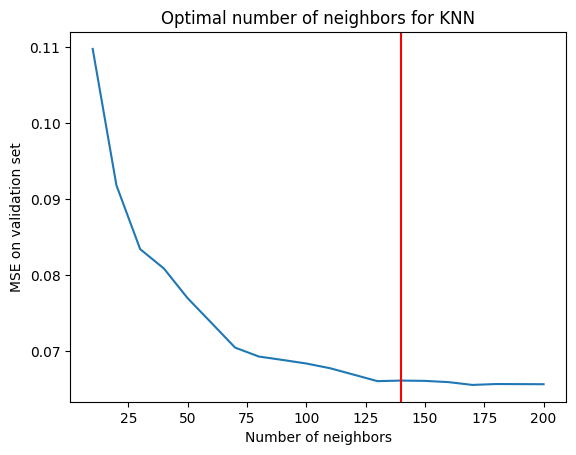

In [510]:
# Get the best value for hyperparameter "n neighbors" by computing MSE for a range of values using validation set.
x, y = [], []
for n in range(10, 210, 10):
    mse = knn_evaluate(val_df, n=n)
    y.append(mse)
    x.append(n)

plt.plot(x, y)
plt.axvline(x=140, color='r')
plt.title('Optimal number of neighbors for KNN')
plt.xlabel('Number of neighbors')
plt.ylabel("MSE on validation set")
plt.show()

In [519]:
# Recommender system using KNN
def knn_recommend(userId, n):
    user_rated_jokes = user_joke_matrix.loc[userId]
    rated_joke_ids = user_rated_jokes[user_rated_jokes > 0].index.tolist()
    # using similarity df to find the nearest neighbour
    user_similarity_series = cosine_similarity_df.loc[userId]
    orders_similarities = user_similarity_series.sort_values(ascending=False)
    user_idxs = orders_similarities[1:n+1].index.tolist()
    # creating a set to store the indexes of jokes that have been rated highly by the customer's nearest neighbors
    joke_ids = set()
    # select the highest ratings made by nearest neighbor and adding it to joke_ids
    for userId in user_idxs:
        ratings = user_joke_matrix.loc[userId]
        ratings = ratings[ratings > 5].index.values
        for jokeId in ratings:
            joke_ids.add(jokeId)
    print('------------------------------------------')
    print('Recommended jokes based on similar users:')
    print('------------------------------------------')
    for jokeId in list(joke_ids)[:5]:
        if jokeId not in rated_joke_ids:
            print(jokeId, sample_df[sample_df['jokeId']==jokeId].iloc[0]['jokeText'])

In [520]:
# Checking recommendations for user based on the similar users ratings
knn_recommend(46, n=140)

------------------------------------------
Recommended jokes based on similar users:
------------------------------------------
16 Q. What is orange and sounds like a parrot?  

A. A carrot.

17 How many men does it take to screw in a light bulb? 

One...men will screw anything. 

23 Q: What is the Australian word for a boomerang that won't
   come back? 

A: A stick

25 Two kindergarten girls were talking outside: one said, "You
won't believe what I saw on the patio yesterday--a condom!"

The second girl asked, "What's a patio?"

28 A mechanical, electrical and a software engineer from Microsoft were
driving through the desert when the car broke down. The mechanical
engineer said "It seems to be a problem with the fuel injection system,
why don't we pop the hood and I'll take a look at it." To which the
electrical engineer replied, "No I think it's just a loose ground wire,
I'll get out and take a look." Then, the Microsoft engineer jumps in.
"No, no, no. If we just close up all the w

## 6.3 Performance evaluation for KNN

In [514]:
# Finally compute the MSE score using the test set using the same evaluation function as above.
knn_evaluate(test_df, n=140)

0.06737553635437356

# 7. Conclusion

In this notebook we developed two different models for joke recommendations. The first model used SVD to perform dimentionality reduction on user joke ratings data and recommended new jokes to the user based on higest similarity of the users highest rated joke.

Similarly, In the second model we performed SVD on the dataset and recommended new jokes to the user based on user similarity using KNN method. We got n closet neighnour of the user based on their ratings history and provided recommendation based on the negibours heigest rated jokes.

We used MSE to evaluate both of these models. While the MSE scores are very close the SVD joke similarity model slightly out performend the knn similarity model.

In conclusion, We recommend using both joke similarity and user similarity methods to provide a diverse set of recommendation to the users.